In [19]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline

In [35]:
# code from matplotlib example
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Prepare environment

In [ ]:
!mkdir checkpoints
!wget -O checkpoints/last_checkpoint https://www.dropbox.com/s/cs6zd9yntn6ixea/last_checkpoint?dl=1

!wget -O parameters.zip https://www.dropbox.com/s/n2jbjyq32x6jgr6/parameters.zip?dl=1
!unzip parameters.zip

In [3]:
import torch
import matplotlib.pyplot as plt
from model.transformer_model import TransformerModel
from model.text import BPEVocab
from model.utils import pad_sequence
from config import get_model_config
from pprint import pprint
import numpy as np
from ipywidgets import interactive
from itertools import product

model_config = get_model_config()

In [4]:
pprint(model_config)

{'annealing': 0,
 'annealing_topk': None,
 'attn_dropout': 0.1,
 'beam_size': 3,
 'bpe_codes_path': './parameters/bpe.code',
 'bpe_vocab_path': './parameters/bpe.vocab',
 'checkpoint_path': './checkpoints/last_checkpoint',
 'diversity_coef': 0,
 'diversity_groups': 1,
 'dropout': 0.1,
 'embed_dropout': 0.1,
 'embeddings_size': 768,
 'ff_dropout': 0.1,
 'length_penalty': 0.6,
 'max_seq_len': 256,
 'n_heads': 12,
 'n_layers': 12,
 'n_pos_embeddings': 512,
 'n_segments': None}


In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
vocab = BPEVocab.from_files(model_config.bpe_vocab_path, model_config.bpe_codes_path)

In [7]:
model = TransformerModel(n_layers=model_config.n_layers,
                         n_embeddings=len(vocab),
                         n_pos_embeddings=model_config.n_pos_embeddings,
                         embeddings_size=model_config.embeddings_size,
                         padding_idx=vocab.pad_id,
                         n_heads=model_config.n_heads,
                         dropout=model_config.dropout,
                         embed_dropout=model_config.embed_dropout,
                         attn_dropout=model_config.attn_dropout,
                         ff_dropout=model_config.ff_dropout,
                         bos_id=vocab.bos_id,
                         eos_id=vocab.eos_id,
                         max_seq_len=256,
                         beam_size=3,
                         length_penalty=0.6,
                         n_segments=model_config.n_segments,
                         sample=False,
                         annealing_topk=None,
                         annealing=0.6,
                         diversity_coef=0,
                         diversity_groups=1)

In [8]:
torch.set_grad_enabled(False)
state_dict = torch.load(model_config.checkpoint_path, map_location=lambda storage, loc: storage)

if 'model' in state_dict:
    state_dict = state_dict['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print('Done')

Done


In [9]:
def model_responce(encoded_context, max_len=255):
    prevs = [[vocab.bos_id]]
    
    dump = []
    
    for _ in range(max_len):
        prevs_t = torch.tensor(prevs, dtype=torch.long, device=device)
        
        current_dump = []
        outputs = model.decode(prevs_t, encoded_context, dump=current_dump)

        _, m_idx = torch.max(outputs[:, -1, :], dim=-1)
        m_idx = m_idx.item()
        
        dump.append((m_idx, current_dump))

        prevs[0].append(m_idx)

        if m_idx == vocab.eos_id:
            break
    return prevs[0], dump

In [10]:
def read_info(max_sequences=4, max_len=255):
    info = []
    for _ in range(max_sequences):
        new_info = input('Info: ').lower().strip()
        
        if new_info == 'exit':
            break
        
        if not new_info.endswith('.'):
            new_info += '.'
            
        info += vocab.string2ids(new_info)
    
    if info:
        info = [vocab.info_bos_id] + info[:model.n_pos_embeddings-2] + [vocab.info_eos_id]
        info = [torch.tensor(info, dtype=torch.long)]
        info = pad_sequence(info, batch_first=True, padding_value=vocab.pad_id).to(device)
        
    return info


In [11]:
def simple_interactive():
    dump = []
    
    info = read_info()
    info_tokens = info.cpu().numpy()[0]
    
    dialog = []
    
    while True:
        new_message = input('H: ').lower().strip()
        
        if new_message == 'exit':
            break
        
        dialog += [vocab.talker1_bos_id] + vocab.string2ids(new_message) + [vocab.talker1_eos_id]
        
        t_dialog = [torch.tensor(dialog[-model_config.embeddings_size+1:], dtype=torch.long)]
        t_dialog = pad_sequence(t_dialog, batch_first=True, padding_value=vocab.pad_id).to(device)
        
        dialog_tokens = t_dialog.cpu().numpy()[0]
        
        context = []
        if len(info):
            context.append(info)
        context.append(t_dialog)

        encoded_context = [model.encode(c) for c in context]
        
        res_indx, attention_dump = model_responce(encoded_context)
        res_indx = res_indx[1:-1]
        
        print(f'B: {vocab.ids2string(res_indx)}')
        
        dump.append((attention_dump, info_tokens, dialog_tokens))
        
        dialog += [vocab.talker2_bos_id] + res_indx + [vocab.talker2_eos_id]
        
    return dump

In [12]:
dump = simple_interactive()

Info: i am bus driver.
Info: exit
H: hello, how are you?
B: i 'm doing well , how are you ? 
H: i am fine. what do yoy do for live?
B: i drive a truck for a living . 
H: exit


In [15]:
def parse_attention_dump(i_dump, *, n_layers=12, n_heads=12, n_context=3):
    '''if info is enpty n_context=2'''
    assert n_context == 3, 'Not implemented'
    attention_dump, info_tokens, dialog_tokens = i_dump

    out_ids = []

    dialog_weights = np.zeros((n_layers, n_heads, len(dialog_tokens), len(attention_dump)))
    info_weights = np.zeros((n_layers, n_heads, len(info_tokens), len(attention_dump)))
    self_weights = np.zeros((n_layers, n_heads, len(attention_dump), len(attention_dump))) + np.nan

    for i, (idx, d) in enumerate(attention_dump):
        out_ids.append(idx)

        for l_i, l in enumerate(range(0, n_context * n_layers, n_context)):
            for h in range(n_heads):
                
                current_dump = d[l]
                self_weights[l_i, h, :i+1, i] = current_dump[2][0, h, -1].numpy()

                current_dump = d[l+1]
                info_weights[l_i, h, :, i] = current_dump[2][0, h, -1].numpy()

                current_dump = d[l+2]
                dialog_weights[l_i, h, :, i] = current_dump[2][0, h, -1].numpy()

    out_ids = [vocab.bos_id] + out_ids
    
    return self_weights, info_weights, dialog_weights, out_ids

In [16]:
p_dump = []
for dump_i in dump:
    
    self_weights, info_weights, dialog_weights, out_ids = parse_attention_dump(dump_i)
    info_ids, dialog_ids = dump_i[1:]
    
    p_dump.append((self_weights, info_weights, dialog_weights, info_ids, dialog_ids, out_ids))

In [58]:
def plot_heatmap(data, row_labels, col_labels, title=''):
    
    for i, (d, r) in enumerate(zip(data, row_labels)):
        fig, ax = plt.subplots(figsize=(len(col_labels), len(r)))
        im, cbar = heatmap(d, r, col_labels,  ax=ax, cmap="YlGn", cbarlabel=title)
        texts = annotate_heatmap(im, valfmt="{x:.1f} t")

        fig.tight_layout()

In [51]:
from ipywidgets import interactive


def interactive_plot(iteration=0, layer=1, head=1):
    sw = p_dump[iteration][0]
    iw = p_dump[iteration][1]
    dw = p_dump[iteration][2]
    
    it = [vocab.id2token[i] for i in p_dump[iteration][3]]
    dt = [vocab.id2token[i] for i in p_dump[iteration][4]]
    ot = [vocab.id2token[i] for i in p_dump[iteration][5]]
    
    plot_heatmap([sw[layer, head],
                  dw[layer, head], 
                  iw[layer, head]], 
                 [ot,
                  dt, 
                  it], 
                 ot[1:], title=f'layer {layer} | head {head}')
    
    
interactive(interactive_plot, iteration=(0, len(p_dump)-1, 1), layer=(0, 11, 1), head=(0, 11, 1))
    


interactive(children=(IntSlider(value=0, description='iteration', max=1), IntSlider(value=1, description='laye…

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


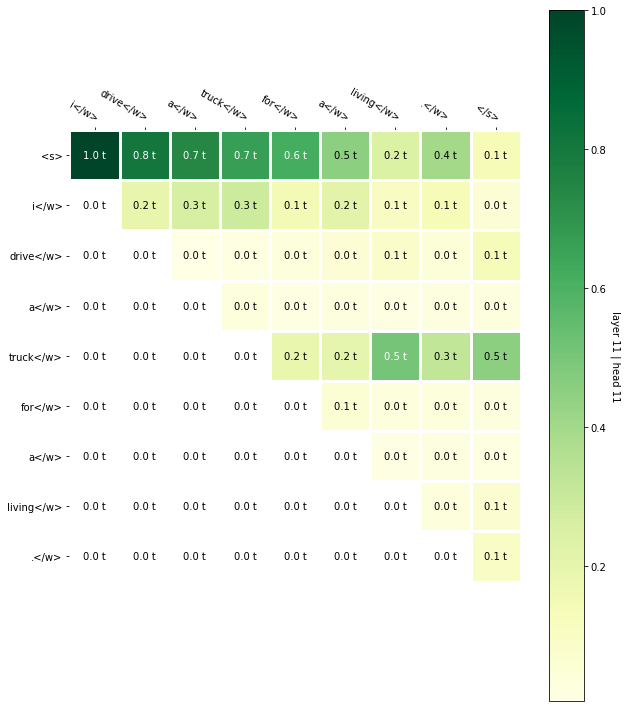

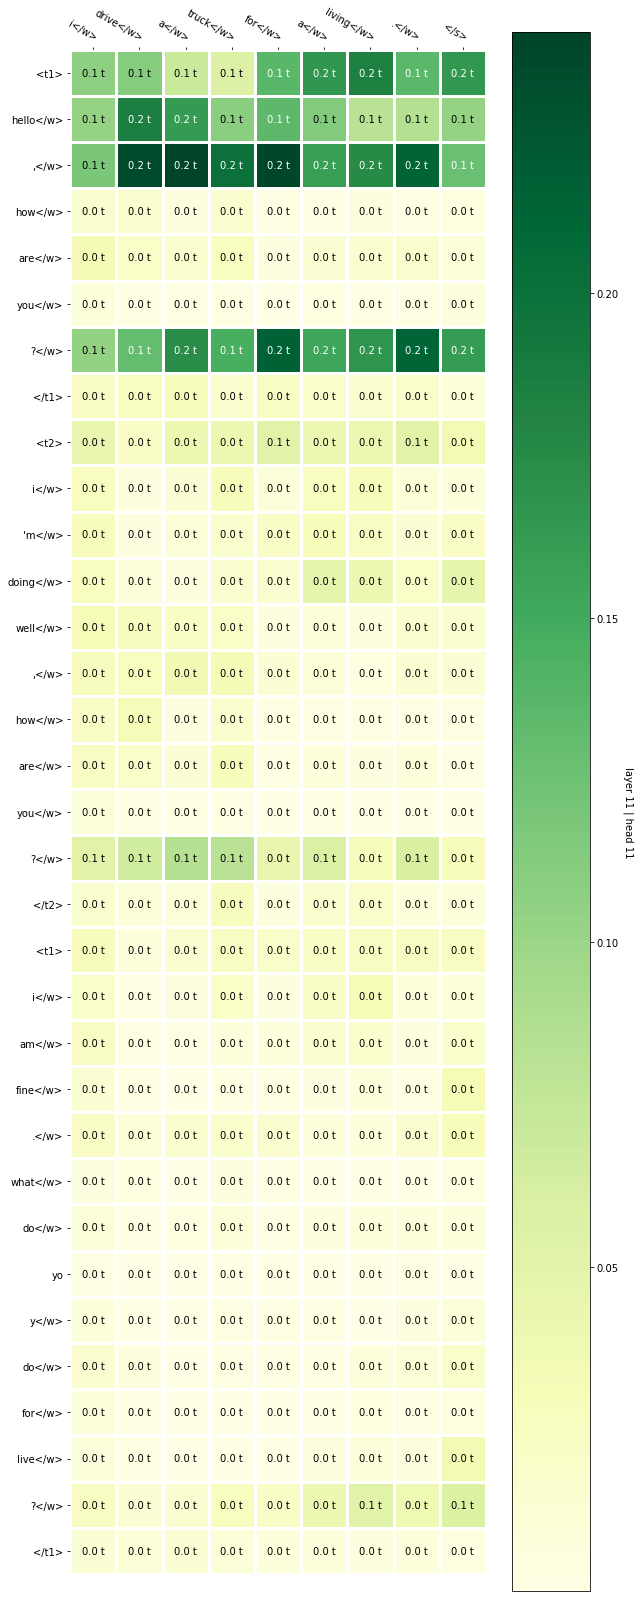

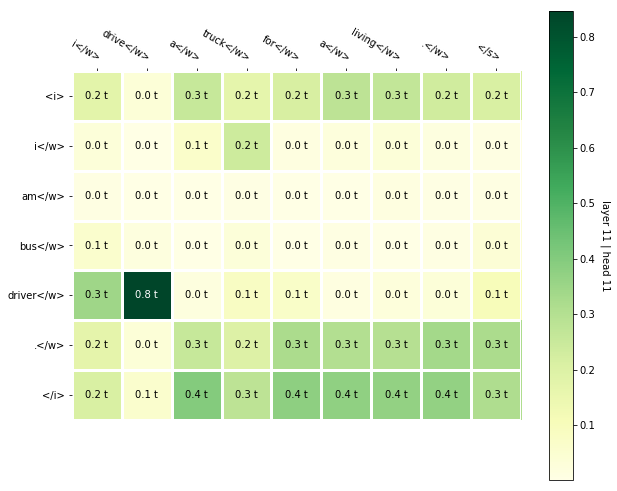

In [59]:
# not interactive example
interactive_plot(iteration=1, layer=11, head=11)

In [52]:
def interactive_average_plot(iteration=0, layer=1):
    
    sw = p_dump[iteration][0]
    iw = p_dump[iteration][1]
    dw = p_dump[iteration][2]
    
    it = [vocab.id2token[i] for i in p_dump[iteration][3]]
    dt = [vocab.id2token[i] for i in p_dump[iteration][4]]
    ot = [vocab.id2token[i] for i in p_dump[iteration][5]]
    
    plot_heatmap([np.mean(sw[layer, :], axis=0),
                  np.mean(dw[layer, :], axis=0), 
                  np.mean(iw[layer, :], axis=0)], 
                 [ot,
                  dt, 
                  it], 
                 ot[1:], title=f'layer {layer}')
    
    
interactive(interactive_average_plot, iteration=(0, len(p_dump)-1, 1), layer=(0, 11, 1), head=(0, 11, 1))

interactive(children=(IntSlider(value=0, description='iteration', max=1), IntSlider(value=1, description='laye…

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


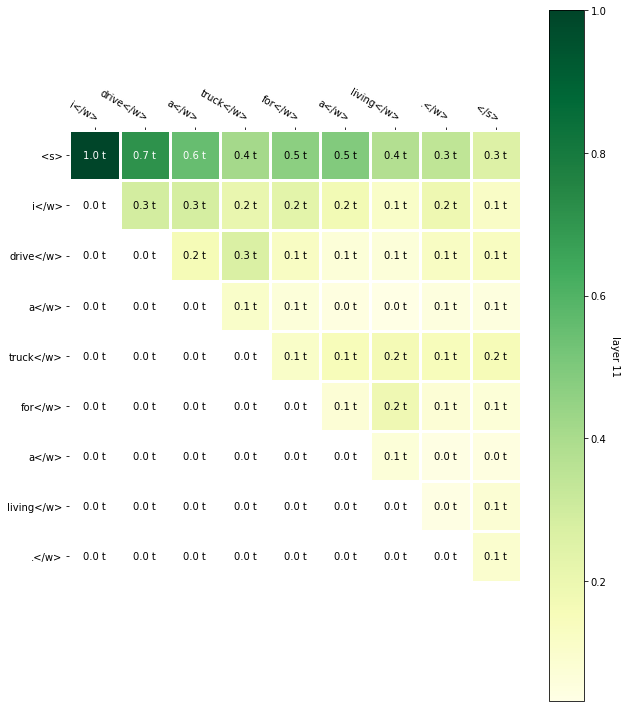

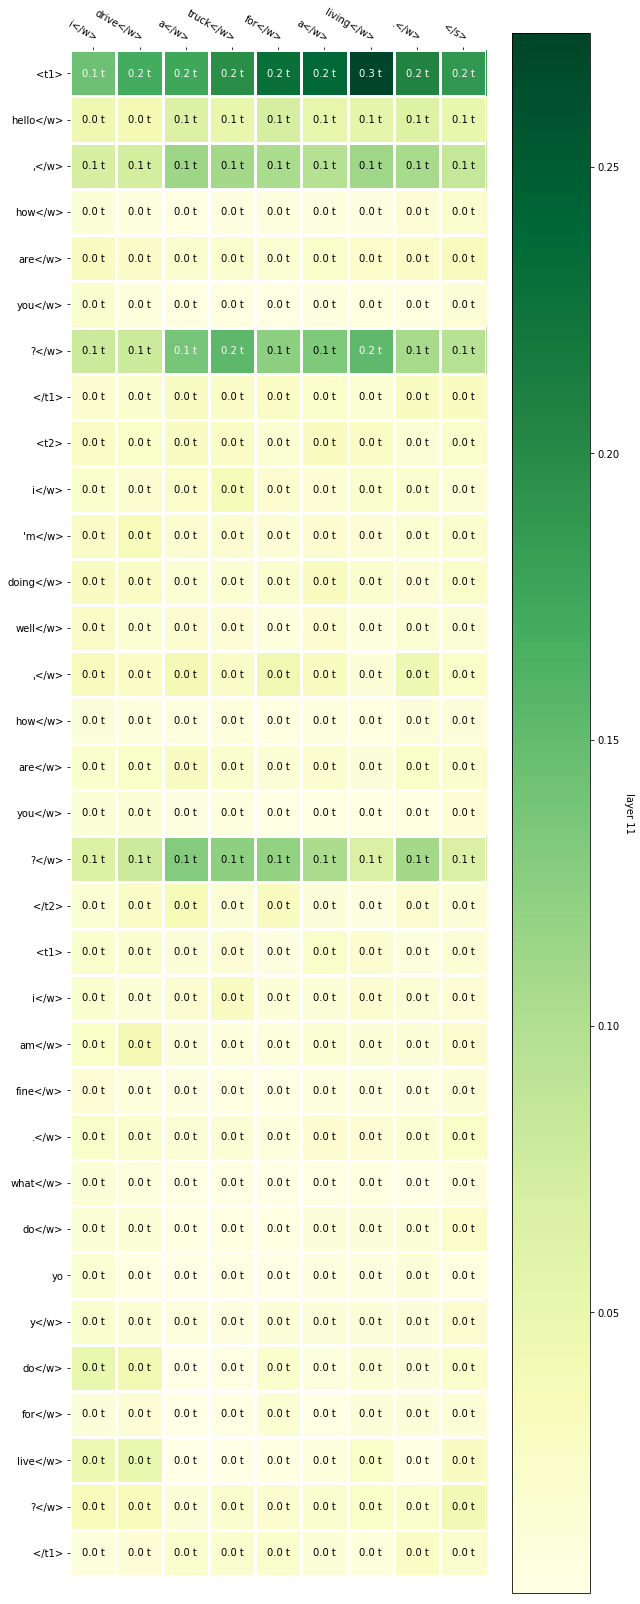

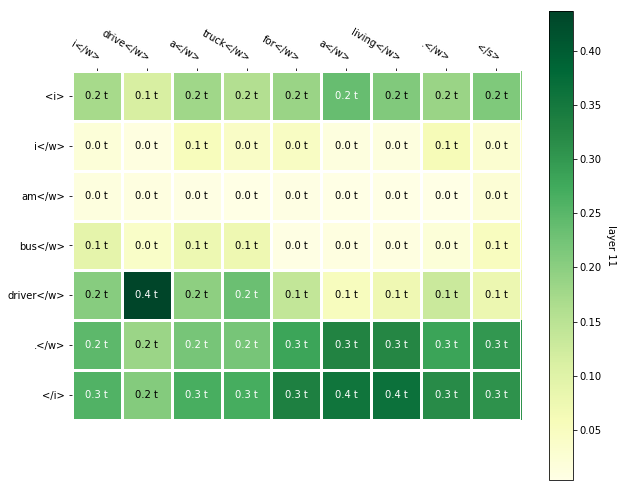

In [54]:
# not interactive example
interactive_average_plot(iteration=1, layer=11)